In [2]:
# Execute when running on Google Colab
!pip install neograd

In [1]:
# Execute when running locally
import sys
sys.path.insert(0, '../tests')
import _setup
!pip install matplotlib
import matplotlib.pyplot as plt

You should consider upgrading via the '/Users/pranavsastry/Documents/py/neograd/tests/venv/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import neograd as ng
import numpy as np
from neograd.nn.loss import SoftmaxCE
from neograd.nn.optim import Adam
from neograd.autograd.utils import grad_check
from neograd.nn.utils import get_batches
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
X, y = load_digits(return_X_y=True) # load data
X_train, X_test, y_train, y_test = train_test_split(X, y) # split data into train and test set

In [4]:
num_train, num_test = X_train.shape[0], X_test.shape[0] # number of train and test examples
num_iter = 200 # number of iterations
batch_size = 200 # batch size in each iteration

In [5]:
# normalize inputs
X_train_norm = (X_train - np.mean(X_train, axis=1, keepdims=True))/np.std(X_train, axis=1, keepdims=True)
X_test_norm = (X_test - np.mean(X_test, axis=1, keepdims=True))/np.std(X_test, axis=1, keepdims=True)

In [6]:
# Convert normalized inputs and targets to Tensor
X_train = ng.tensor(X_train_norm[:num_train,:].reshape(num_train,8,8))
X_test = ng.tensor(X_test_norm[:num_test,:].reshape(num_test,8,8))
y_train = ng.tensor(np.eye(10)[y_train[:num_train]])
y_test = ng.tensor(y_test[:num_test])

In [7]:
# Define the model
class NN(ng.nn.Model):
  def __init__(self):
    self.conv = ng.nn.Sequential(
      ng.nn.Conv2D((3,3)),
      ng.nn.ReLU()
    )
    self.stack = ng.nn.Sequential(
        ng.nn.Linear(36,10)
    )

  def forward(self, inputs):
    conv_outputs = self.conv(inputs)
    conv_outputs_flattened = conv_outputs.reshape((inputs.shape[0], 36))
    return self.stack(conv_outputs_flattened)

In [8]:
# configure the model
model = NN()
loss_fn = SoftmaxCE(axis=1)
optim = Adam(model.get_params(), 5e-3)

In [9]:
CHKPT_PATH = 'model_checkpoints'
chkpt = ng.Checkpoint(model, CHKPT_PATH)

In [10]:
# train the model
for i in range(num_iter):
  for batch_input, batch_target in get_batches(X_train, y_train, batch_size):
    optim.zero_grad()
    outputs = model(batch_input)
    loss = loss_fn(outputs, batch_target)
    loss.backward()
    optim.step()
  if i%50==0:
    chkpt.add(
      loss=loss.data.tolist(),
      epoch=i
    )
    print(f"iter {i+1}/{num_iter}\nloss: {loss.data}\n")


PARAMS SAVED at model_checkpoints/8cede7231f393aa5/ec3c69d3659e0a3b.hkl

iter 1/200
loss: 8.445636671511181


PARAMS SAVED at model_checkpoints/8cede7231f393aa5/f8554a27b44033be.hkl

iter 51/200
loss: 0.6569712488731276


PARAMS SAVED at model_checkpoints/8cede7231f393aa5/43743c18b8f4fcb9.hkl

iter 101/200
loss: 0.1779055641114179


PARAMS SAVED at model_checkpoints/8cede7231f393aa5/6b0aa9f8138bec1a.hkl

iter 151/200
loss: 0.09356414221153893



In [11]:
# evaluate the model
with model.eval():
  test_outputs = model(X_test)
  probs = ng.nn.Softmax(1)(test_outputs.data)
  preds = np.argmax(probs.data, axis=1)

In [12]:
# get report
report = classification_report(y_test.data.astype(int).flatten(), preds.flatten())
print(report)
accuracy = accuracy_score(y_test.data.astype(int).flatten(), preds.flatten())
print('Accuracy:', accuracy)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        41
           1       0.91      0.97      0.94        40
           2       0.96      0.98      0.97        47
           3       0.92      0.92      0.92        37
           4       0.90      0.98      0.94        55
           5       0.94      0.96      0.95        50
           6       0.95      0.97      0.96        37
           7       0.95      0.88      0.91        48
           8       0.82      0.84      0.83        44
           9       0.98      0.86      0.92        51

    accuracy                           0.93       450
   macro avg       0.93      0.93      0.93       450
weighted avg       0.93      0.93      0.93       450

Accuracy: 0.9311111111111111


In [13]:
print(accuracy_score(y_test.data.astype(int).flatten(), preds.flatten()))

0.9311111111111111


In [14]:
# save the model
ng.save('model.pkl', model)

# save the parameters of the model
model.save('model_params.pkl')

# load the model
model = ng.load('model.pkl')

# load the parameters of the model
model.load('model_params.pkl')

MODEL SAVED to model.pkl

PARAMS SAVED at model_params.pkl

MODEL LOADED from model.pkl

PARAMS LOADED from model_params.pkl



In [15]:
# Display a grid of digits
# num_rows>1 num_cols>1

def plt_digits(num_rows, num_cols, data, label, predicted=None, print_vals=True, figsize=(6,6), h_pad=1, w_pad=0.5):
  fig, axs = plt.subplots(num_rows, num_cols, figsize=figsize)
  assert (num_rows*num_cols<=data.shape[0]) and (num_rows*num_cols<=label.shape[0])
  if predicted is not None:
    assert (num_rows*num_cols<=predicted.shape[0])
  i=0
  for ax in axs:
    for j in range(num_cols):
      ax[j].imshow(data[i], cmap='gray')
      ax[j].axis('off')
      if predicted is not None:
          title = f'Actual: {label[i]}\nPredicted: {predicted[i]}'
      else:
          title = f'Actual: {label[i]}'
      if print_vals:
          ax[j].set_title(title,fontsize=8)
      i+=1
  fig.tight_layout(w_pad=w_pad,h_pad=h_pad)
  plt.show()

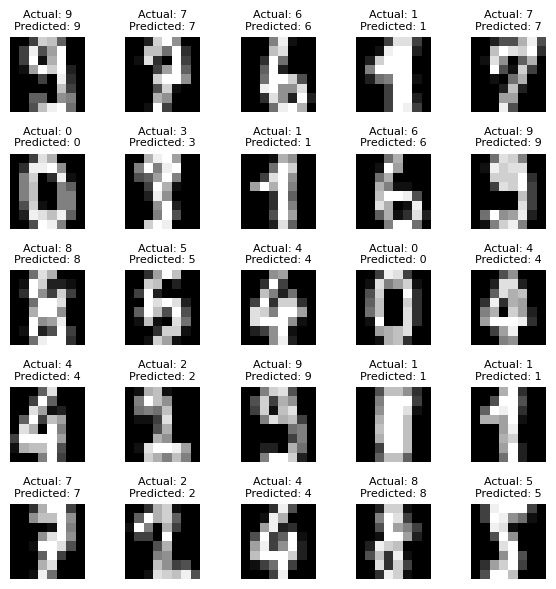

In [16]:
plt_digits(5,5,X_test.data,y_test.data.astype(int),preds)

In [17]:
# save figs

import random
idxs = random.sample(range(0,X_test.shape[0]),10)
assert list(set(idxs))!=idxs, 'There is repetition'
for idx in idxs:
    data = X_test.data[idx]
    label = y_test.data.astype(int)[idx]
    predicted = preds[idx]
    title = f'Actual: {label}\nPredicted: {predicted}'
    plt.axis('off')
    plt.title(title)
    plt.imshow(data, cmap='gray')
    plt.savefig(f'{idx}.png', bbox_inches='tight')